# MRIO Workshop

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [318]:
var_list = ['Z', 'V', 'Y', 'F_NRG', 'F_NRG_hh', 'F_GHG', 'F_GHG_hh']
Z, V, Y, F_NRG, F_NRG_hh, F_GHG, F_GHG_hh, year_list = [], [], [], [], [], [], [], []

for var in var_list:
    for year in range(1995, 2010):
        if year not in year_list:
            year_list.append(year)
        if var.split('_')[0] == 'F' and var.split('_')[-1] != 'hh':
            my_col = 0
        else:
             my_col = [0, 1]
        if var.split('_')[-1] == 'hh':
            my_header = 0
        else:
            my_header = [0, 1]
            
        df = pd.read_csv('Data/clean_data/' + var + '_' + str(year) + '.csv', header=my_header, index_col=my_col).dropna(how='all', axis=0)
        eval(var).append(df)
        
# ensure that indecies match up

new_names = {'ROM':'ROU', 'RoW':'ROW', 'c1':'c01', 'c2':'c02', 'c3':'c03', 'c4':'c04', 'c5':'c05', 'c6':'c06', 'c7':'c07', 'c8':'c08', 'c9':'c09'}
for i in range(len(year_list)):
    Y[i] = Y[i].rename(columns=new_names, index=new_names).swaplevel(axis=1)
    Y[i] = Y[i].reindex(sorted(Y[i].columns), axis=1).reindex(sorted(Y[i].index), axis=0)
    
    Z[i] = Z[i].rename(columns=new_names, index=new_names)
    Z[i] = Z[i].reindex(sorted(Z[i].columns), axis=1).reindex(sorted(Z[i].index), axis=0)
    
    V[i] = V[i].rename(columns=new_names, index=new_names)
    V[i] = V[i].reindex(sorted(V[i].columns), axis=1).reindex(sorted(V[i].index), axis=0)
    
    F_NRG[i] = F_NRG[i].rename(columns=new_names, index=new_names)
    F_NRG[i] = F_NRG[i].reindex(sorted(F_NRG[i].columns), axis=1)
    F_GHG[i] = F_GHG[i].rename(columns=new_names, index=new_names)
    F_GHG[i] = F_GHG[i].reindex(sorted(F_GHG[i].columns), axis=1)
    
    F_NRG_hh[i] = F_NRG_hh[i].reindex(Y[i].index.levels[0], axis=1)
    F_GHG_hh[i] = F_GHG_hh[i].reindex(Y[i].index.levels[0], axis=1)

# 5. Calculating energy and emissions consumption-based accounts

For reference, use:  
http://www.see.leeds.ac.uk/teaching-resources/exercise-pages/l4-input-output-tutorial-201617/  
http://mathesaurus.sourceforge.net/matlab-numpy.html 

### 5.1. The UK's production and conumption based GHG emissions from 1995-2009

In [320]:
UK_consumption = []
UK_production = []
for i in range(len(year_list)):
    # territorial emissions
    UK_prod = float(F_GHG[i]['GBR'].sum(axis=1)) + float(F_GHG_hh[i]['GBR'])
    UK_production.append(UK_prod)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(F_GHGx, L)
    temp = np.matmul(temp, Y_UK)
    
    UK_cons = temp + float(F_GHG_hh[i]['GBR'])
    UK_consumption.append(UK_cons[0][0])

In [322]:
UK_co2e = pd.DataFrame()
UK_co2e['Consumption'] = UK_consumption
UK_co2e['Production'] = UK_production
UK_co2e['Year'] = year_list

Text(0.5,1,'UK')

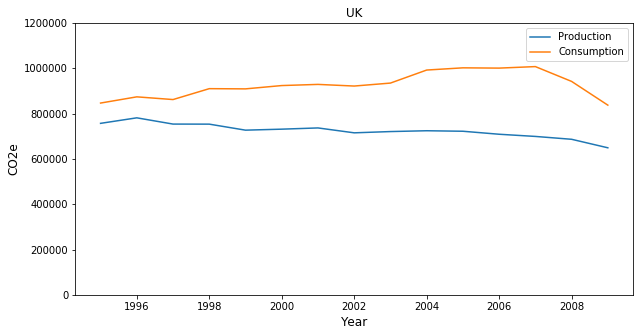

In [323]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_co2e.plot(ax=ax, x='Year', y='Production')
UK_co2e.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('CO2e', fontsize=12)
ax.set_ylim([0,1200000])
ax.set_title('UK')

### 5.2. The UK's production and conumption based GHG emissions from 1995-2009

In [325]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
country_list = F_NRG_hh[0].columns.tolist()

BRIC_consumption = []
BRIC_production = []
for i in range(len(year_list)):
    # territorial emissions
    BRIC_prod = float(F_NRG[i][BRIC_countries].sum(axis=1)) + float(F_NRG_hh[i][BRIC_countries].sum(axis=1))
    global_prod = float(F_NRG[i].sum(axis=1)) + float(F_NRG_hh[i].sum(axis=1))
    BRIC_production.append(BRIC_prod/global_prod * 100)

    # consumption based emissions
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    temp_1 = np.matmul(F_NRGx, L)
    
    BRIC_cons = 0
    global_cons = 0
    for c in country_list:
        Y_temp = np.array(Y[i][[c]]).sum(axis=1).reshape(1435, 1)
        temp_2 = np.matmul(temp_1, Y_temp)
        cons = temp_2 + float(F_NRG_hh[i][[c]].sum(axis=1))
        global_cons += cons[0][0]
        if c in BRIC_countries:
            BRIC_cons += cons[0][0]
        
    BRIC_consumption.append(BRIC_cons/global_cons * 100)

In [326]:
BRIC_energy = pd.DataFrame()
BRIC_energy['Consumption'] = BRIC_consumption
BRIC_energy['Production'] = BRIC_production
BRIC_energy['Year'] = year_list

Text(0.5,1,'BRIC Countries')

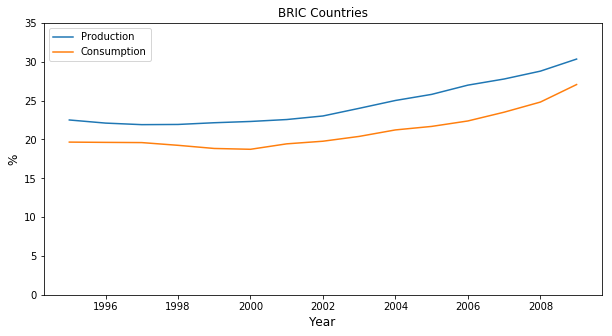

In [327]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

BRIC_energy.plot(ax=ax, x='Year', y='Production')
BRIC_energy.plot(ax=ax, x='Year', y='Consumption')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,35])
ax.set_title('BRIC Countries')

### 5.3. What proportion of the UK’s GHG footprint is sourced from BRIC nations?

In [329]:
BRIC_countries = ['BRA', 'RUS', 'IND', 'CHN']
UK_BRIC = []
sectors = 35

for i in range(len(year_list)):
    x = np.array(Z[i].sum(axis=1) + Y[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    BRIC_value = 0
    for c in BRIC_countries:
        temp_1 = temp.T[c].sum().sum()
        BRIC_value += temp_1
    
    UK_BRIC.append(BRIC_value/UK_consumption[i] * 100)   

In [330]:
UK_BRIC_ghg = pd.DataFrame()
UK_BRIC_ghg['BRIC_prop'] = UK_BRIC
UK_BRIC_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - BRIC Proportion')

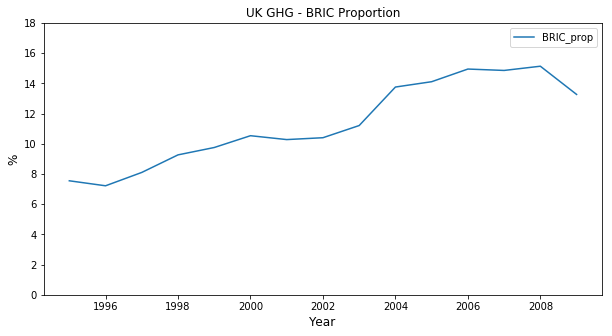

In [331]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_BRIC_ghg.plot(ax=ax, x='Year', y='BRIC_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,18])
ax.set_title('UK GHG - BRIC Proportion')

### 5.4. What proportion of UK’s GHG footprint can be shown to originate from the agricultural industry?

In [334]:
UK_agriculture = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_GHGx = np.array(F_GHG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)

    temp = np.matmul(np.diag(F_GHGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    agri_value = temp.T.swaplevel(axis=1)['c01'].sum().sum()
    
    UK_agriculture.append(agri_value/UK_consumption[i] * 100)   

In [336]:
UK_agri_ghg = pd.DataFrame()
UK_agri_ghg['agri_prop'] = UK_agriculture
UK_agri_ghg['Year'] = year_list

Text(0.5,1,'UK GHG - Agriculture Proportion')

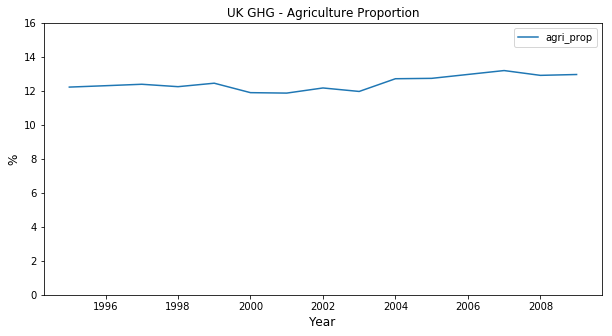

In [337]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_agri_ghg.plot(ax=ax, x='Year', y='agri_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,16])
ax.set_title('UK GHG - Agriculture Proportion')

In [15]:
# above answer is off by about 1% for each year .. 

### 6.1. Make Y_G8 a ‘1 x 1435’ vector showing the final demand of the G8 nations and use this to find the total energy footprint of G8 nations 

In [344]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()

In [345]:
regions = len(country)
final_demand = 5
G8_Y_agg = np.zeros((regions*final_demand, 1))
G8_lookup = np.zeros((regions,1))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_Y_agg[(j*final_demand)-final_demand:j*final_demand] = np.ones((final_demand,1))

In [348]:
G8_energy_cons = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    Y_G8 = np.matmul(np.array(Y[i]),  G8_Y_agg)
    
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_G8)
    
    temp_1 = np.matmul(np.array(F_NRG_hh[i]), G8_lookup)
    
    G8_cons = temp[0][0] + temp_1[0][0]
    
    G8_energy_cons.append(G8_cons)

In [349]:
G8_cons_nrg = pd.DataFrame()
G8_cons_nrg['nrg_cons'] = G8_energy_cons
G8_cons_nrg['Year'] = year_list

Text(0.5,1,'G8')

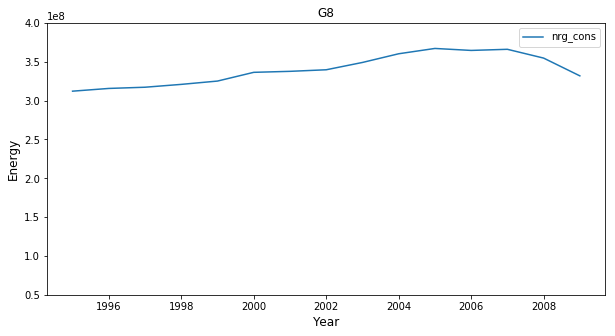

In [351]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

G8_cons_nrg.plot(ax=ax, x='Year', y='nrg_cons')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Energy', fontsize=12)
ax.set_ylim([50000000, 400000000])
ax.set_title('G8')

### 6.2. What proportion of the UK energy footprint is sourced from G8 nations?

Using aggregate matrices

In [426]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())

G8_lookup = np.zeros((regions,1))
G8_F_agg = np.zeros((1,regions*sectors))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_F_agg[0][(j*sectors)-sectors:j*sectors] = np.ones((sectors,1)).reshape(1, sectors)[0]

In [475]:
G8_energy_cons = []
UK_consumption_nrg = []
UK_G8_prop = []

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)
    
    # UK energy footprint
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))  
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_UK)
    UK_cons = temp + float(F_NRG_hh[i]['GBR'])
    UK_consumption_nrg.append(UK_cons[0][0])
    
    # from G8
    F_G8 = G8_F_agg * np.array(F_NRG[i])
    F_G8x = F_G8 / (x.reshape(1, 1435))
    temp = np.matmul(F_G8x, L)
    temp = np.matmul(temp, Y_UK)
    G8_energy_cons.append(temp[0][0])
    
    a = G8_energy_cons[i] / UK_consumption_nrg[i] * 100
    
    UK_G8_prop.append(a)

Text(0.5,1,'UK NRG - G8 Proportion')

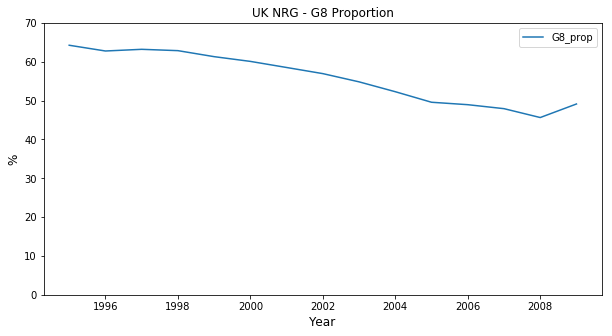

In [477]:
UK_G8_prop_df = pd.DataFrame()
UK_G8_prop_df['G8_prop'] = UK_G8_prop
UK_G8_prop_df['Year'] = year_list

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_G8_prop_df.plot(ax=ax, x='Year', y='G8_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,70])
ax.set_title('UK NRG - G8 Proportion')

Calculating individual nation's contributions as earlier (Q 5.3)

In [478]:
'''
G8_countries = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
UK_G8 = []
UK_consumption_nrg = []
sectors = 35

for i in range(len(year_list)):
    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))
    for j in range(len(x)):
        if x[j]==0:
            x[j]=0.000000001 # do this to avoid trying to divide my zero later
        else:
            pass
    x = x.reshape(1435,1)
    big_x = x.repeat(len(x), axis=1)
    x_t = np.matrix.transpose(big_x)
    
    A = np.array(Z[i]) / x_t
    I = np.identity(len(Z[i]))
    L = np.linalg.inv(I-A)
    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))
    
    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)
    
    # UK energy footprint
    temp = np.matmul(F_NRGx, L)
    temp = np.matmul(temp, Y_UK)
    UK_cons = temp + float(F_NRG_hh[i]['GBR'])
    UK_consumption_nrg.append(UK_cons[0][0])
    
    temp = np.matmul(np.diag(F_NRGx[0]), L)
    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)[0]))
    temp = pd.DataFrame(temp, index=Z[0].index, columns=Z[0].columns) # change back into df to more easily extract the countries
    
    # G8 proportions
    G8_value = 0
    for c in G8_countries:
        temp_1 = temp.T[c].sum().sum()
        G8_value += temp_1
    
    UK_G8.append(G8_value/UK_consumption_nrg[i] * 100)

UK_G8_prop = pd.DataFrame()
UK_G8_prop['G8_prop'] = UK_G8
UK_G8_prop['Year'] = year_list

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))

UK_G8_prop.plot(ax=ax, x='Year', y='G8_prop')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('%', fontsize=12)
ax.set_ylim([0,70])
ax.set_title('UK NRG - G8 Proportion')
'''

"\nG8_countries = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']\nUK_G8 = []\nUK_consumption_nrg = []\nsectors = 35\n\nfor i in range(len(year_list)):\n    x = np.array(Y[i].sum(axis=1) + Z[i].sum(axis=1))\n    for j in range(len(x)):\n        if x[j]==0:\n            x[j]=0.000000001 # do this to avoid trying to divide my zero later\n        else:\n            pass\n    x = x.reshape(1435,1)\n    big_x = x.repeat(len(x), axis=1)\n    x_t = np.matrix.transpose(big_x)\n    \n    A = np.array(Z[i]) / x_t\n    I = np.identity(len(Z[i]))\n    L = np.linalg.inv(I-A)\n    F_NRGx = np.array(F_NRG[i]) / (x.reshape(1, 1435))\n    \n    Y_UK = np.array(Y[i][['GBR']]).sum(axis=1).reshape(1435, 1)\n    \n    # UK energy footprint\n    temp = np.matmul(F_NRGx, L)\n    temp = np.matmul(temp, Y_UK)\n    UK_cons = temp + float(F_NRG_hh[i]['GBR'])\n    UK_consumption_nrg.append(UK_cons[0][0])\n    \n    temp = np.matmul(np.diag(F_NRGx[0]), L)\n    temp = np.matmul(temp, np.diag(Y_UK.reshape(1, 1435)

### 6.3. Making a smaller version of the WIOD matrix using aggregation matrices

In [539]:
G8 = ['CAN','DEU','FRA','GBR','ITA','JPN','RUS','USA']
country = Y[0].columns.levels[0].tolist()
regions = len(country)
sectors = len(Z[0].columns.levels[1].tolist())

G8_lookup = np.zeros((regions,1))
G8_agg = np.zeros((2*sectors,regions*sectors))

for i in range(len(country)):
    if country[i] in G8:
        G8_lookup[i] = 1
        
for i in range(len(G8_lookup)):
    j = i+1 # because indexing starts at 0 in python
    if G8_lookup[i] == 1:
        G8_agg[0:sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)
    else:
        G8_agg[sectors:2*sectors, j*sectors-(sectors):j*sectors] = np.identity(sectors)